# 0. Download dataset

In [1]:
# %%shell
# git clone https://github.com/ltphuongunited/dl4cv.git
# cd dl4cv/
# mkdir checkpoints/
# gdown https://drive.google.com/uc?id=1WEWBSy39Jhy51vUEK9f2CyDli-5rkXtX
# unzip data.zip

In [2]:
# %%shell
# pip install gdown
# pip install timm
# pip install natten
# pip install einops

# 1. Import libraries

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torchvision import datasets, transforms
import random
from sklearn.metrics import classification_report
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# 2. Prepare Dataset

## Visualize Images

In [4]:
# Set random seeds
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Path to the data
data_dir = Path("data/")

unique_labels =  ['early_blight', 'mosaic_virus', 'yellow_leaf_curl_virus', 'healthy', 'bacterial_spot', 'septoria_leaf_spot', 'late_blight', 'target_spot', 'two-spotted_spider_mite', 'powdery_mildew', 'leaf_mold']


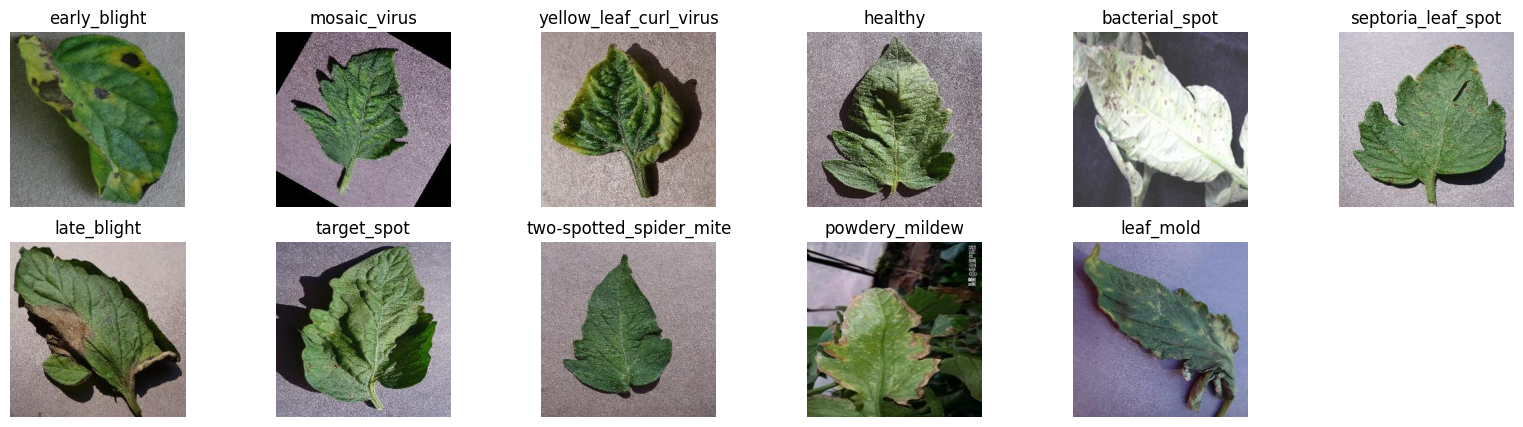

In [7]:
def load_unique():
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(data_dir):
        for file in os.listdir(os.path.join(data_dir,folder)):
            filepath = os.path.join(data_dir, folder, file)
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images_for_plot.append(image)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (20,5))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 2
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

Random image path: data/late_blight/a07f7609-5248-4cbc-a277-5d962e1d0dd1___GHLB2 Leaf 148.4.JPG
Image class: late_blight
Image height: 256
Image width: 256


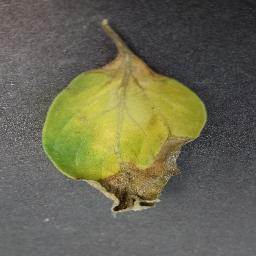

In [8]:
# 1. Get all image paths (* means "any combination")S
image_path_list = list(data_dir.glob("*/*"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## Processing & Augment Data

In [9]:
# Declare transform steps for train, valid and test sets
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

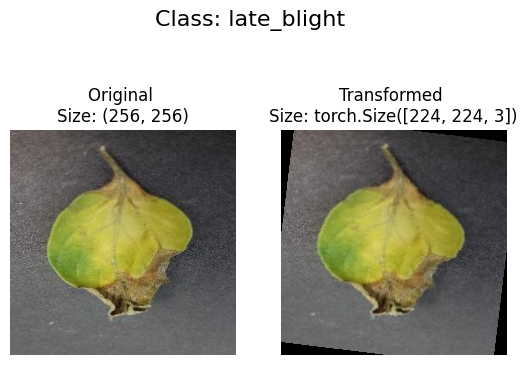

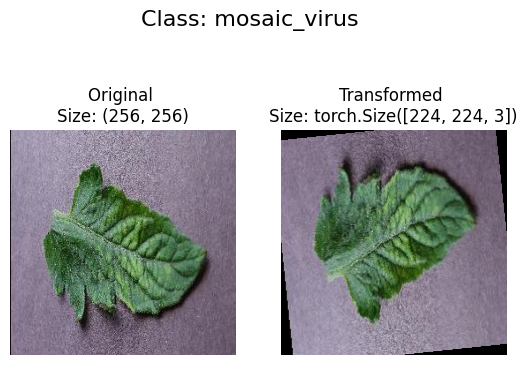

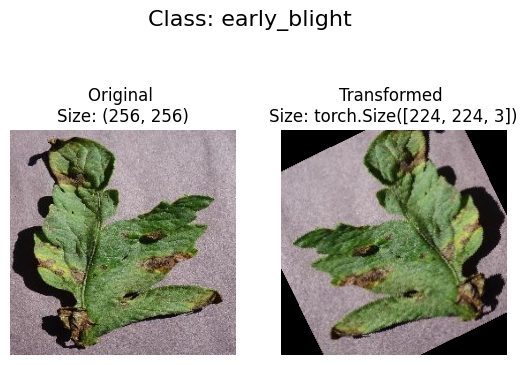

In [10]:
plot_transformed_images(image_path_list, transform=train_transforms, n=3)

In [11]:
# Create dataset
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataset = datasets.ImageFolder(root=data_dir)

print(f"Dataset:\n{dataset}")

Dataset:
Dataset ImageFolder
    Number of datapoints: 32535
    Root location: data


In [12]:
# Can also get class names as a dict
class_dict = dataset.class_to_idx
class_dict

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'mosaic_virus': 5,
 'powdery_mildew': 6,
 'septoria_leaf_spot': 7,
 'target_spot': 8,
 'two-spotted_spider_mite': 9,
 'yellow_leaf_curl_virus': 10}

In [13]:
# Count total number of images
total_images = len(dataset)
total_images

32535

## Split dataset with ratio train:val:test=7:2:1

In [14]:
# Count number of images in each set
train_size = int(0.7 * total_images)
valid_size = int(0.2 * total_images)
test_size = total_images - train_size - valid_size

# Use random to shuffle the data
indices = list(range(total_images))
random.shuffle(indices)

# Divide the data into train, valid, and test sets
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size+valid_size]
test_indices = indices[train_size+valid_size:]

# Create datasets for each set
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print('Training set: {} images'.format(len(train_dataset)))
print('Validation set: {} images'.format(len(valid_dataset)))
print('Testing set: {} images'.format(len(test_dataset)))

Training set: 22774 images
Validation set: 6507 images
Testing set: 3254 images


In [15]:
# Apply transform steps to each dataset
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = valid_transforms
test_dataset.dataset.transform = test_transforms

# Create dataloaders for each set
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
img_custom, label_custom = next(iter(train_dataloader))
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# 3. Model

## 3.5. ConvNeXt - V2

### Define model

In [17]:
from models.convnext.convnextv2 import *
model = convnextv2_femto(pretrained=True, num_classes=len(class_dict)).to(device)


### Training

In [18]:
# Set number of epochs
NUM_EPOCHS = 20

model_name = 'convnextv2.pth'
checkpoints = os.path.join('checkpoints',model_name)
model = model.to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(  model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        model_name=checkpoints,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3684 | train_acc: 0.8795 | val_loss: 0.1357 | val_acc: 0.9555 | lr: 0.000100 | 
Save best model on epoch 1
Epoch: 2 | train_loss: 0.0906 | train_acc: 0.9719 | val_loss: 0.1160 | val_acc: 0.9625 | lr: 0.000100 | 
Save best model on epoch 2
Epoch: 3 | train_loss: 0.0566 | train_acc: 0.9817 | val_loss: 0.1306 | val_acc: 0.9579 | lr: 0.000100 | 
Epoch: 4 | train_loss: 0.0505 | train_acc: 0.9840 | val_loss: 0.0995 | val_acc: 0.9678 | lr: 0.000100 | 
Save best model on epoch 4
Epoch: 5 | train_loss: 0.0403 | train_acc: 0.9868 | val_loss: 0.1103 | val_acc: 0.9691 | lr: 0.000100 | 
Save best model on epoch 5
Epoch: 6 | train_loss: 0.0246 | train_acc: 0.9924 | val_loss: 0.1000 | val_acc: 0.9717 | lr: 0.000100 | 
Save best model on epoch 6
Epoch: 7 | train_loss: 0.0351 | train_acc: 0.9888 | val_loss: 0.0776 | val_acc: 0.9784 | lr: 0.000100 | 
Save best model on epoch 7
Epoch: 8 | train_loss: 0.0347 | train_acc: 0.9894 | val_loss: 0.1106 | val_acc: 0.9645 | lr: 0.000100 |

### Plot loss and accuracy curves

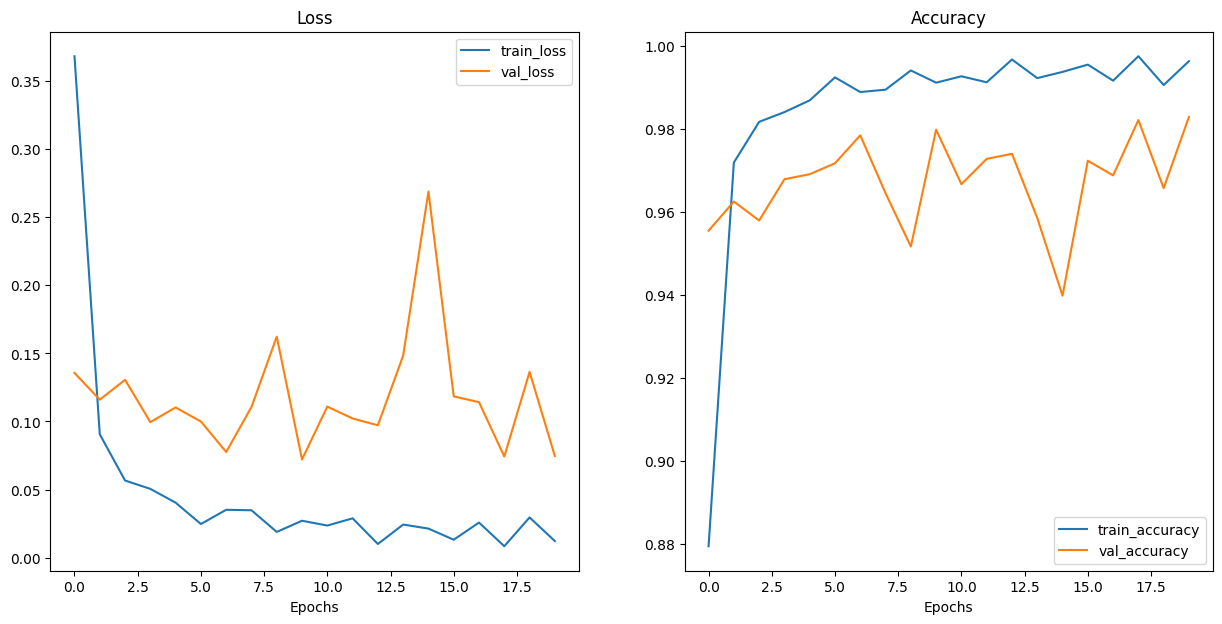

In [19]:
plot_loss_curves(model_results)

### Testing

In [20]:
labels, predicts = evaluate(model, test_dataloader, device, checkpoints)
# Compute classification report
report = classification_report(labels, predicts)
print(report)

  0%|          | 0/102 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       350
           1       0.95      0.96      0.96       292
           2       1.00      1.00      1.00       393
           3       0.98      0.96      0.97       397
           4       0.99      0.99      0.99       355
           5       1.00      0.99      0.99       280
           6       0.97      1.00      0.98       140
           7       0.98      0.97      0.98       372
           8       1.00      0.94      0.97       217
           9       0.99      1.00      0.99       212
          10       0.98      1.00      0.99       246

    accuracy                           0.98      3254
   macro avg       0.98      0.98      0.98      3254
weighted avg       0.98      0.98      0.98      3254



Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

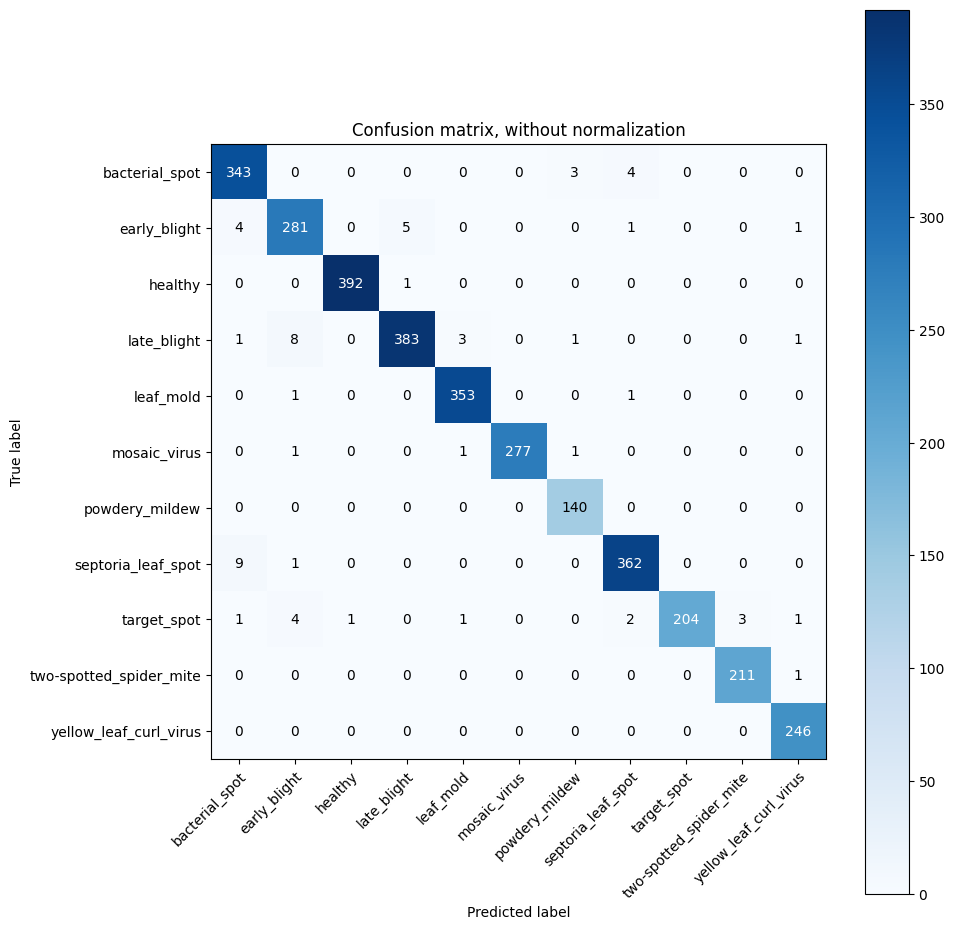

In [21]:
cm = metrics.confusion_matrix(labels, predicts)
np.set_printoptions(precision=2)
#Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = class_dict.keys())
plt.show()

### Predict random image

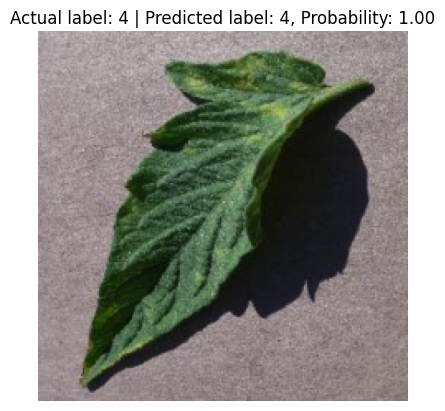

In [22]:
predict_random_image(model, test_dataloader, device, checkpoints)